# Language Detection
In the previous notebook, we found that a significant number of records are missing a stated *language* within the record. Additionally, we found in our work in Phase 1 it is not uncommon for the stated language of the record to be inaccurate. This could be for a variety of reasons: lack of clarity as to what *language* is actually referring to (i.e. the language of the item, container, or the metadata record itself), perhaps some level of increased discoverability if the work is labeled with **en** (English).

To examine these issues more closely, we will detect the languages used within the records, compare that against theior stated languages, and see any patterns that emerge.

First we will import several of the necessary packages, set up our directory, and import our data.

In [22]:
import seaborn as sns # data visualizations
from pathlib import Path
import numpy as np
import pandas as pd #Creating dataframe and manipulating data
from py3langid.langid import LanguageIdentifier, MODEL_FILE
from matplotlib import pyplot as plt

In [23]:
# Data Directory
data_dir = Path('../data')
input_dir = data_dir / 'input'
output_dir = data_dir / 'output'
# Loading in dataset
df = pd.read_csv(output_dir / '03_labeled_data.csv', parse_dates=['created', 'deposited'],
                 infer_datetime_format=True, index_col = 'Index')

## Publisher Bins
Not all publishers are of the same size, obviously. Thus it makes it difficult to draw any meaningful comparisons between Elsevier BV (*n* = 19377) and, for instance, the South African National Biodiversity Institute (*n* = 5). So while we cannot have multiple large publishers such as Elsevier BV, we can group publishers to create bins of similar size and make comparisons between the publisher sizes.

We will create five bins, or groups, with each bin having ~20000 records. The `XS` bin has publishers who have 0 to 75 records in the dataset, `S`: 76-1000, `M`:1001-5000, `L`:5001-10000 (this bin is comprised of Springer and Wiley exclusively), `XL`:10000+ (Elsevier BV exclusively).

In [24]:
pub_count = df.publisher.value_counts()
cut_bins = pd.cut(pub_count, bins=[0,75,1000,5000,10050,20000], labels=['XS','S','M','L','XL'])
def bin_applicator(record):
    try:
        pub = record['publisher']
        locator = cut_bins.loc[cut_bins.index == pub]
        locList = locator.to_list()
        return locList[0]
    except:
        return None
df['publisher_bin'] = df.apply(bin_applicator, axis=1)
df.publisher_bin.value_counts()

XS    20761
M     20749
S     20420
XL    19604
L     18443
Name: publisher_bin, dtype: int64

## Detecting Languages
We'll use `py3langid` as we did previously, with the same language list as before. While `py3langid` is optomized for python3 and is several times faster than the original, it is important to note that due to the nature of the language detection we will be doing, it may take a minute or two, but no longer than that. We will check each record across three fields, *abstract*, *title*, and *container-title*. These are the fields that have some of the most text, and thus can give us the most confident results. We'll set a probability threshold of `.9` to help insure that we are only saying a language is present when the model is very confident.

### Matching
After detecting the langauge used in the records, we will then see if the `detected_lang` matches the record's stated *language*. In doing this we will label the record with a `0` if the stated language matches detected language, `1` if the stated language **does not** match detected language), or `2` if the multiple detected languages, but one of the detected languages matches the stated language). 

### Language Type
Finally, we will apply an additional code to each record: `0` if the detected language is English, `1` if the detected language is any single non-english language, `2` for multilingual records.

In [25]:
identifier = LanguageIdentifier.from_pickled_model(MODEL_FILE, norm_probs = True)
lang_list = ['af', 'am', 'ar', 'as', 'az', 'be', 'bg', 'bn', 'br', 
             'bs', 'ca', 'cs', 'cy', 'da', 'de', 'dz', 'el', 'en', 'eo', 
             'es', 'et', 'eu', 'fa', 'fi', 'fo', 'fr', 'ga', 'gl', 'gu', 
             'he', 'hi', 'hr', 'ht', 'hu', 'hy', 'is', 'it', 'ja', 'jv', 
             'ka', 'kk', 'km', 'kn', 'ko', 'ku', 'ky', 'la', 'lb', 'lo', 
             'lt', 'lv', 'mg', 'mk', 'ml', 'mn', 'mr', 'ms', 'mt', 'ne', 
             'nl', 'no', 'oc', 'or', 'pa', 'pl', 'ps', 'pt', 'qu', 'ro', 
             'ru', 'rw', 'se', 'si', 'sk', 'sl', 'sq', 'sr', 'sv', 'sw', 
             'ta', 'te', 'th', 'tl', 'tr', 'ug', 'uk', 'ur', 'vi', 'vo', 
             'wa', 'xh', 'zh', 'zu']
identifier.set_languages(langs=lang_list)
# Check across multiple fields within each record for the languages present.
def record_lang_checker(record):
    #These fields have the most text which will provide the most accurate language detection
    fields = ['abstract', 'title', 'container-title']
    lang_list = []
    for col in fields:
        try:
            detect = identifier.classify(record[col].lower())
            # Setting a .9 probability threshold for asserting the language is indeed in the record, lower probability increases the chances of a false detection
            if detect[1] > .9:
                lang_list.append(detect[0])
            else:
                pass
        except:
            pass
    #If no language is detected, return None
    if len(lang_list) == 0:
        return None
    else:
        #Returning all of the detected languages for each record
        return list(set(lang_list))
df['detected_lang'] = df.apply(record_lang_checker, axis=1)
detected_languages = df.explode('detected_lang')
detected_languages.detected_lang.nunique()

71

In [26]:
def detection_match(record):
    try:
        #Filtering out records with no stated language
        if record['language'] == np.nan:
            return 1
        else:
            #checking if stated language matches detected language
            if record['language'] in record['detected_lang']:
                #Stated language is within the detected languages, but there are multiple languages
                #present in the record
                if len(record['detected_lang']) > 1:
                    return 2
                #Stated language matches detected language
                else:
                    return 0
            #Stated and detected languages do not match
            else:
                return 1
    except:
        return None
df['lang_match'] = df.apply(detection_match, axis=1)
df.lang_match.value_counts()

0.0    71731
1.0    21859
2.0     3508
Name: lang_match, dtype: int64

In [27]:
def lang_type(record):
    try:
        #Checking the monolingual records if they are english or non-english
        if len(record['detected_lang']) == 1:
            if record['detected_lang'][0] == 'en':
                return 0
            else:
                return 1
        else:
            #Multilingual records
            if len(record['detected_lang']) > 1:
                return 2
            else:
                return None
    except:
        return None

df['lang_type'] = df.apply(lang_type, axis=1)
df.lang_type.value_counts()

0.0    82058
1.0     9087
2.0     5953
Name: lang_type, dtype: int64

## Differences in Errors Between Language Types
After detecting the languages and coding the records, we can see that there are a large number of records in which the `detected_lang` does not match the stated language. One possible explanation is the high number of records that simply do not have a stated language. We will explore this below.

Additionally, we can see that English is the predominant language of the dataset. Next, we'll take a look at errors per record in regards to the different language types: English-monolingual, Non-English-monolingual, and Multilingual.

First, we'll take a look at the number of errors per language.

In [28]:
grouped_langs = detected_languages.groupby('detected_lang')
group_total_errors = grouped_langs.agg({'total_errors': 'sum', 'DOI': 'count'}).sort_values(by='DOI', ascending=False)
group_total_errors[:20]

,total_errors,DOI
detected_lang,,
en,44749.0,87302
de,3746.0,4015
fr,2555.0,3358
es,1671.0,1664
pt,1414.0,1327
ms,1164.0,913
it,566.0,622
nl,442.0,529
ru,831.0,418


<AxesSubplot: xlabel='detected_lang', ylabel='total_errors'>

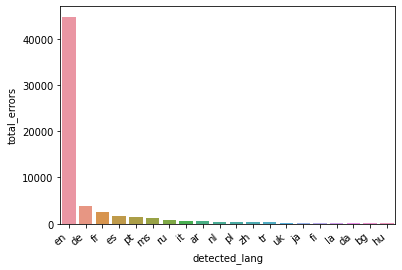

In [29]:
top_20 = group_total_errors.sort_values(by='total_errors', ascending=False)[:20]
t20plt = sns.barplot(data=top_20, x=top_20.index, y='total_errors')
t20plt.set_xticklabels(t20plt.get_xticklabels(), rotation=40, ha='right', fontsize=10)
t20plt

<AxesSubplot: xlabel='detected_lang', ylabel='total_errors'>

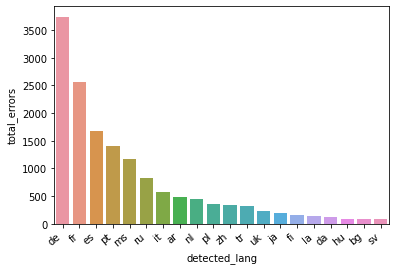

In [30]:
#Now we'll remove English, to better visualize other languages
no_en = group_total_errors.drop('en')
top_20 = no_en.sort_values(by='total_errors', ascending=False)[:20]
t20plt = sns.barplot(data=top_20, x=top_20.index, y='total_errors')
t20plt.set_xticklabels(t20plt.get_xticklabels(), rotation=40, ha='right', fontsize=10)
t20plt

In [31]:
#Now we'll change from total errors, to the mean number of errors by language
group_avg_errors = grouped_langs.agg({'total_errors': 'mean', 'DOI': 'count'}).sort_values(by='total_errors', ascending=False)
group_avg_errors

,total_errors,DOI
detected_lang,,
hi,3.000000,1
zh,2.324138,145
sr,2.047619,21
be,2.000000,1
he,2.000000,1
...,...,...
br,0.625000,8
ht,0.555556,18
en,0.512577,87302


<AxesSubplot: xlabel='detected_lang', ylabel='total_errors'>

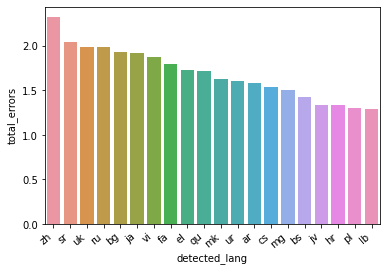

In [32]:
#We'll remove the languages with only a couple of records
filtered = group_avg_errors.loc[group_avg_errors.DOI > 5].sort_values(by='total_errors', ascending=False)
top_20 = filtered[:20]
t20plt = sns.barplot(data=top_20, x=top_20.index, y='total_errors')
t20plt.set_xticklabels(t20plt.get_xticklabels(), rotation=40, ha='right', fontsize=10)
t20plt

### Individual Languages
We see that, as mentioned, English is by far the most represented language in the dataset, and, consequently, has the most errors. Once removing english, we see that German (de), French (fr), Spanish (es), Portugese (pt), and Malay (ms) are the next top 5 in total errors, but that tends to be a reflection of the quantity of  in the dataset.

However, when we look at the average (arithmetic mean) of the errors per language, we do see that there are a number of languages from the top 20 of total errors there:

Chinese (zh), Russian (ru), Ukranian (uk), Bulgarian (bg), Japanese (ja), Arabic (ar).

Now, we'll take a look at the differences between language types.

In [33]:
multi = df.loc[df.lang_type == 2]
non_english = df.loc[df.lang_type == 1]
english = df.loc[df.lang_type == 0]

In [34]:
multi_error_rate = multi.total_errors.sum()/len(multi)
eng_error_rate = english.total_errors.sum()/len(english)
non_eng_error_rate = non_english.total_errors.sum()/len(non_english)

print("{:0.2f} errors per english, monolingual record".format(eng_error_rate))
print("{:0.2f} errors per non-english, monolingual record".format(non_eng_error_rate))
print("{:0.2f} errors per multilingual record".format(multi_error_rate))

0.49 errors per english, monolingual record
1.04 errors per non-english, monolingual record
0.97 errors per multilingual record


To visualize this data, we'll look at the error rates for each of these language types and break them up by their publisher bin.

Then We'll take a look at any differences between the languages.

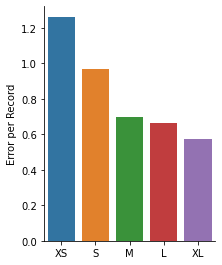

In [35]:
#Multilingual Records
mlt = sns.catplot(data=multi,x='publisher_bin', y='total_errors', kind='bar', height=4, aspect=.8, order=['XS', 'S', 'M', 'L', 'XL'], errorbar=None)
mlt.set_axis_labels('', 'Error per Record')
mlt

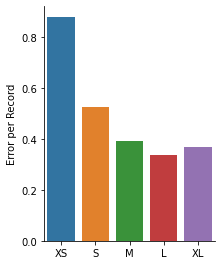

In [36]:
#English Monolingual Records
en_only = sns.catplot(data=english, x='publisher_bin', y='total_errors', kind='bar', height=4, aspect=.8, order=['XS', 'S', 'M', 'L', 'XL'], errorbar=None)
en_only.set_axis_labels('', 'Error per Record')
en_only

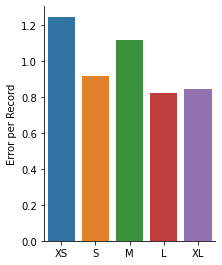

In [37]:
#Non-English Monolingual Records
non_en_plt = sns.catplot(data=non_english, x='publisher_bin', y='total_errors', kind='bar', height=4, aspect=.8, order=['XS', 'S', 'M', 'L', 'XL'], errorbar=None)
non_en_plt.set_axis_labels('', 'Error per Record')
non_en_plt

### Differences in Language Types
We can see that the publisher bins generally change between groups in a similar fashion. The error rate for all seems to be highest in non-English monolingual records, and at its lowest in English monolingual records.

Consistent throughout all groups the XS publisher bin has the highest error rate.

Finally, we'll take a look to see any differences in the presence of a stated language between the language types.

In [38]:
multi_no_lang = (multi.language.isna().sum()/len(multi)) *100
eng_no_lang = (english.language.isna().sum()/len(english)) *100
non_eng_no_lang = (non_english.language.isna().sum()/len(non_english)) * 100

print("{:0.2f}% english, monolingual records with no stated language".format(eng_no_lang))
print("{:0.2f}% non_english, monolingual records with no stated language".format(non_eng_no_lang))
print("{:0.2f}% multilingual records with no stated language".format(multi_no_lang))

16.16% english, monolingual records with no stated language
43.61% non_english, monolingual records with no stated language
37.56% multilingual records with no stated language


<function matplotlib.pyplot.show(close=None, block=None)>

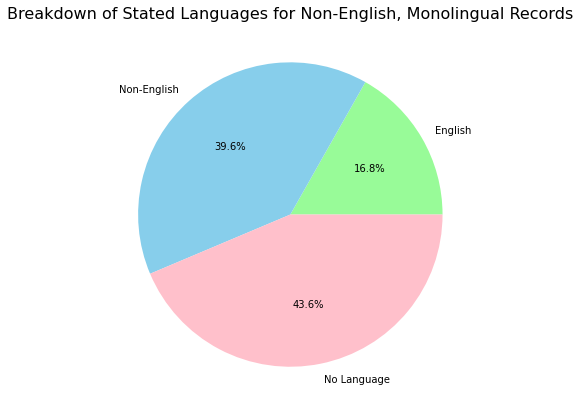

In [39]:
def en_stated(lang):
    try:
        if lang == 'en':
            return 1
        elif lang in lang_list:
            return 0
        else:
            return None
    except:
        return None
    
find_stated = non_english.language.map(lambda x: en_stated(x))
enStated = find_stated.sum()
nonenStated = len(find_stated.loc[find_stated == 0])
non_eng_no_lang = non_english.language.isna().sum()
labels = ['English', 'Non-English', 'No Language']
data = [enStated, nonenStated, non_eng_no_lang]
colors = ['palegreen','skyblue', 'pink']
fig = plt.figure(figsize = (10,7))
plt.pie(data, labels = labels, autopct='%.1f%%', colors=colors)
plt.title('Breakdown of Stated Languages for Non-English, Monolingual Records', fontsize=16)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

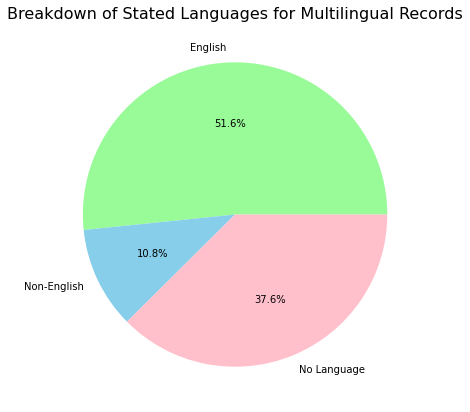

In [40]:
find_stated = multi.language.map(lambda x: en_stated(x))
enStated = find_stated.sum()
nonenStated = len(find_stated.loc[find_stated == 0])
multi_no_lang = multi.language.isna().sum()
labels = ['English', 'Non-English', 'No Language']
data = [enStated, nonenStated, multi_no_lang]
colors = ['palegreen','skyblue', 'pink']
fig = plt.figure(figsize = (10,7))
plt.pie(data, labels = labels, autopct='%.1f%%', colors=colors)
plt.title('Breakdown of Stated Languages for Multilingual Records', fontsize=16)
plt.show

In [41]:
#Looking to see how many multilingual records use english within their records
def has_english(langlist):
    try:
        if 'en' in langlist:
            return 1
        else:
            return 0
    except:
        return None
eng_multi = multi.detected_lang.map(lambda x: has_english(x))
eng_having_rate = (eng_multi.sum()/len(multi)) *100
print("{:0.2f}% of multilingual records have English as one of their languages".format(eng_having_rate))

88.09% of multilingual records have English as one of their languages


In [42]:
df.to_csv(output_dir / '04_language_detection.csv')